In [1]:
import torch
import torch.nn as nn
import pandas as pd
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMFeatureExtractor,LinearPredictor,TransformerGenerator,CNNDiscriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler
from flowprintOptimal.sekigo.flowUtils.flowDatasets import MaxNormalizedDataset,ActivityDataset,BaseFlowDataset,DDQNActivityDataset
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.core import State
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
from flowprintOptimal.sekigo.modeling.loggers import Logger
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import warnings
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import SoftwareUpdateDataProcessor,GamingDownloadDataFrameProcessor
from flowprintOptimal.sekigo.dataAnalysis.dataFrameExtractor import DataFrameExtractor
warnings.filterwarnings('ignore')
from typing import List
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
flow_config = FlowConfig(grain= 1, band_thresholds= [1250])

In [3]:
processor1 = SoftwareUpdateDataProcessor(parquet_path= "data/software-update-1w.parquet")
processor2 = GamingDownloadDataFrameProcessor(parquet_path= "data/2023-12-01--2023-12-31--flowprint.parquet")

initial software update length = 72826
final software update length = 36790
after adding uploads size = 73580


In [4]:
flows = DataFrameExtractor.getData(data_frame_processors= [processor2,processor1],needed_flow_config= flow_config)

In [5]:
class_type_filtered_flows = flows
FT_filtered_flows = list(filter(lambda x : x.class_type != "Download",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "Download",class_type_filtered_flows))

In [6]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .001,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .005,min_activity_for_start_point= 25,sample_wise_train_ratio= 1, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)
all_sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .001,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
all_flows = all_sampler.sampleAndCutToLength(data= class_type_filtered_flows)

{'Video': 0.0008191989266558945, 'Conferencing': 0.002246698061471074, 'Upload': 0.0009995096893413704}
overlapping points = 0
{'Download': 0.004999436005562642}
overlapping points = 0
{'Video': 0.0009095043201455207, 'Conferencing': 0.0024943655643104054, 'Download': 0.0011122128065388648, 'Upload': 0.0011096918598199467}
overlapping points = 0


In [7]:
all_train_dataset = DDQNActivityDataset(flows= all_flows["train_flows"],label_to_index= None)
all_test_dataset = DDQNActivityDataset(flows = all_flows["test_flows"], label_to_index= all_train_dataset.label_to_index)
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)
ood_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= None)

In [8]:
class Predictor(nn.Module):
    def __init__(self,feature_dim,num_classes) -> None:
        super().__init__()
        self.linear = nn.Linear(feature_dim,num_classes)
    def forward(self,X):
        return self.linear(X)
feature_extractor = LSTMFeatureExtractor(lstm_hidden_size= 64,lstm_input_size=4,feature_dim= 64)
classifier = Predictor(feature_dim=64,num_classes= 4)

In [9]:
classification_trainer = NNClassificationTrainer(feature_extractor= feature_extractor,classifier= classifier,device= device,logger= Logger(name= "classification"))
classification_trainer.train(train_dataset= all_train_dataset,test_dataset= all_test_dataset,epochs= 30,batch_size= 64,lr= .0001)

classification ---- 1 metric test_f1 = 0.11055450535601764
classification ---- 1 metric train_f1 = 0.11101232904610468
classification ---- 10 metric train_loss = 1.3878017783164978
classification ---- 20 metric train_loss = 1.3829196214675903
classification ---- 30 metric train_loss = 1.3803474664688111
classification ---- 40 metric train_loss = 1.3790977835655212
classification ---- 50 metric train_loss = 1.3648073554039002
classification ---- 60 metric train_loss = 1.3654117345809937
classification ---- 70 metric train_loss = 1.3509877920150757
classification ---- 80 metric train_loss = 1.3502636075019836
classification ---- 90 metric train_loss = 1.3400566458702088
classification ---- 100 metric train_loss = 1.3143349409103393
classification ---- 110 metric train_loss = 1.3038896679878236
classification ---- 120 metric train_loss = 1.2998436570167542
classification ---- 130 metric train_loss = 1.2679919242858886
classification ---- 140 metric train_loss = 1.2475510239601135
classifi

KeyboardInterrupt: 

In [10]:
features,ood_features = [],[]
labels = []
loader = DataLoader(all_train_dataset,batch_size=64)
ood_loader = DataLoader(ood_dataset,batch_size= 32)

feature_extractor.eval()
with torch.no_grad():
    for batch in loader:
        batch_out = feature_extractor(batch["data"].float().to(device)).cpu().numpy().tolist()
        batch_labels = batch["label"].numpy().tolist()
        labels.extend(batch_labels)
        features.extend(batch_out)


features = np.array(features)
#ood_features = np.array(ood_features)
labels = np.array(labels)

In [11]:
len(features)

99321

In [87]:
real_data = features#list(map(lambda x : x["data"].reshape(-1),train_dataset))
#ood_data = list(map(lambda x : x["data"].reshape(-1),ood_dataset))


In [88]:
real_data = np.array(real_data)
#ood_data = np.array(ood_data)

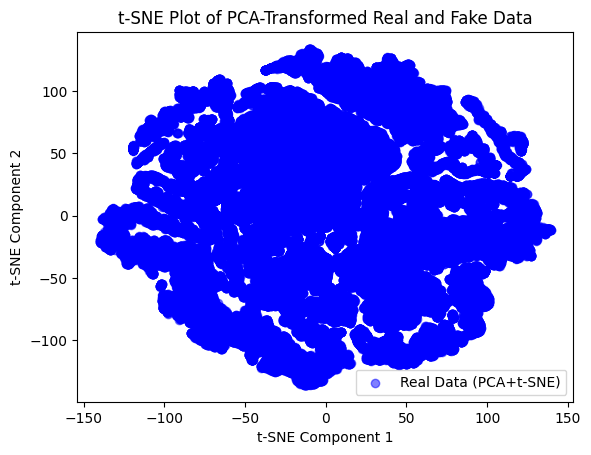

In [90]:


pca = PCA(n_components=30)  # Choose number of principal components
pca_real_data = pca.fit_transform(real_data)

# Fit t-SNE on PCA-transformed real data
tsne = TSNE(n_components=2, random_state=42)
tsne_real_data = tsne.fit_transform(pca_real_data)

# Transform fake data using the learned PCA and t-SNE transformations
#pca_ood_data = pca.transform(ood_data)
#tsne_ood_data = tsne.fit_transform(pca_ood_data)

# Plot t-SNE of PCA-transformed real and fake data
plt.scatter(tsne_real_data[:, 0], tsne_real_data[:, 1], label='Real Data (PCA+t-SNE)', c='blue', alpha=0.5)
#plt.scatter(tsne_ood_data[:, 0], tsne_ood_data[:, 1], label='Fake Data (PCA+t-SNE)', c='red', alpha=0.1)

# Add labels and legend
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Plot of PCA-Transformed Real and Fake Data')
plt.legend()
